#IRS Data Analysis

In [225]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve
)
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import tree
%matplotlib inline

## Load and explore data

In [226]:
os.chdir('/content/drive/My Drive')   # Change working directory to My Drive
# Load the dataset
df = pd.read_csv('IRIS.csv')   # store dataset in df


In [227]:
# Display dataset info
print("Dataset Shape:", df.shape)   # Extract dataset shape
print("\nFirst 5 Rows:")
df.head()   # Preview data

Dataset Shape: (129, 5)

First 5 Rows:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [228]:
# Check for missing data
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


No missing values

In [229]:
# Check number of classes in label
pd.unique(df['species'])   # Targel variable

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

There are 3 unique classes in the speciecs feature, namely Iris-setosa, Iris-versocolor, Iris-virginica

## Preprocessing

### Label Encoding

In [230]:
# Enccode target variable
if df['species'].dtype == 'object':
  le = LabelEncoder() # label encoder
  df['species'] = le.fit_transform(df['species'])   # Fitting label encoder

In [231]:
# Check encoded classes
pd.unique(df['species'])

array([0, 1, 2])

## Data Balancing

In [232]:
# Check for dataset imbalance
print('Number of samples in each class:')
df['species'].value_counts()

Number of samples in each class:


,count
species,
0,50
1,50
2,29


In [233]:
# Balancing datset
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['species']), y=df['species'])
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(df['species']), class_weights)}

# Compute sample weights for each instance
sample_weights = compute_sample_weight(class_weight=class_weights_dict, y=df['species'])


In [234]:
class_weights_dict

{0: 0.86, 1: 0.86, 2: 1.4827586206896552}

In [235]:
# Split features and target
X = df.drop('species', axis=1)
y = df['species']

## Feature Scaling

In [236]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Test-Train Split

In [237]:
# Train-test split
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X_scaled, y, sample_weights, test_size=0.3, stratify=y, random_state=42)

# Assignment:
* Perform Exploratory Data Analysis using descriptive statistics and a different plot
* Discuss your findings

In [238]:
df.describe() # Descibe data prior to scaling

,sepal_length,sepal_width,petal_length,petal_width,species
count,129.000000,129.000000,129.000000,129.000000,129.000000
mean,5.716279,3.057364,3.476744,1.062791,0.837209
std,0.794983,0.453075,1.739231,0.727804,0.768427
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.500000,0.200000,0.000000
50%,5.600000,3.000000,4.000000,1.200000,1.000000
75%,6.300000,3.400000,4.800000,1.600000,1.000000
max,7.700000,4.400000,6.900000,2.500000,2.000000


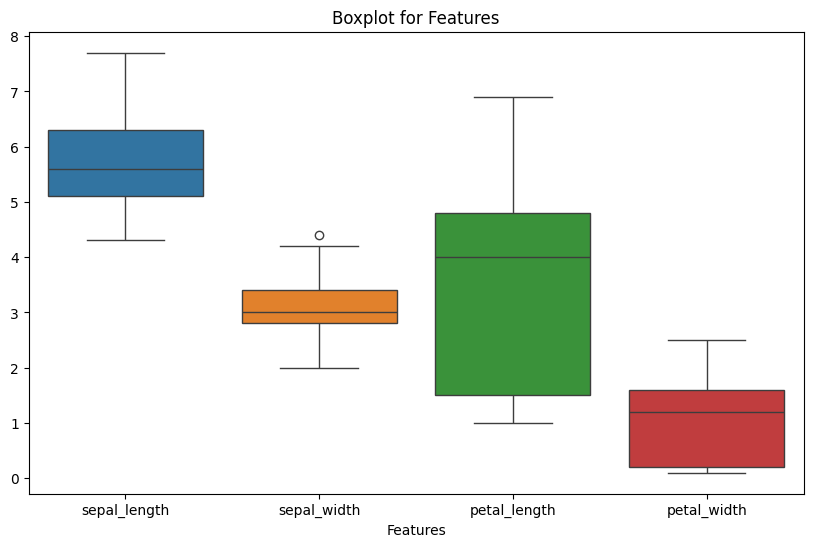

In [239]:
# Boxplots of the data
plt.figure(figsize=(10,6))
sns.boxplot(data=df.drop('species', axis=1))
plt.title('Boxplot for Features')
plt.xlabel('Features')
plt.show()


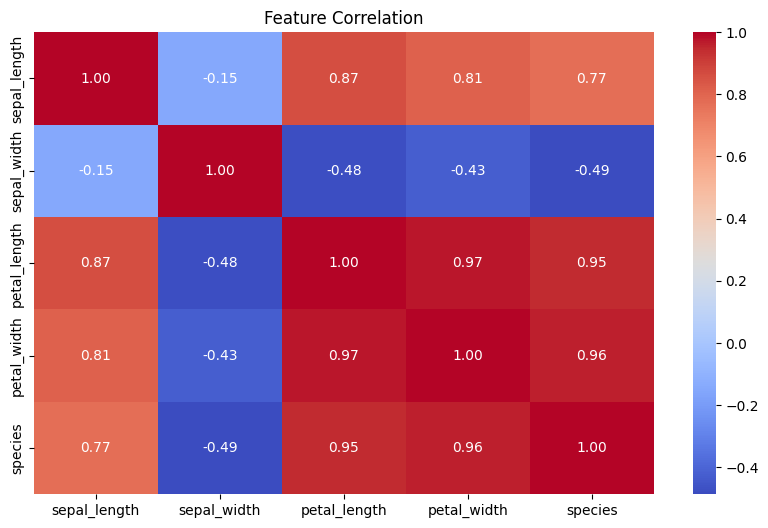

In [240]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

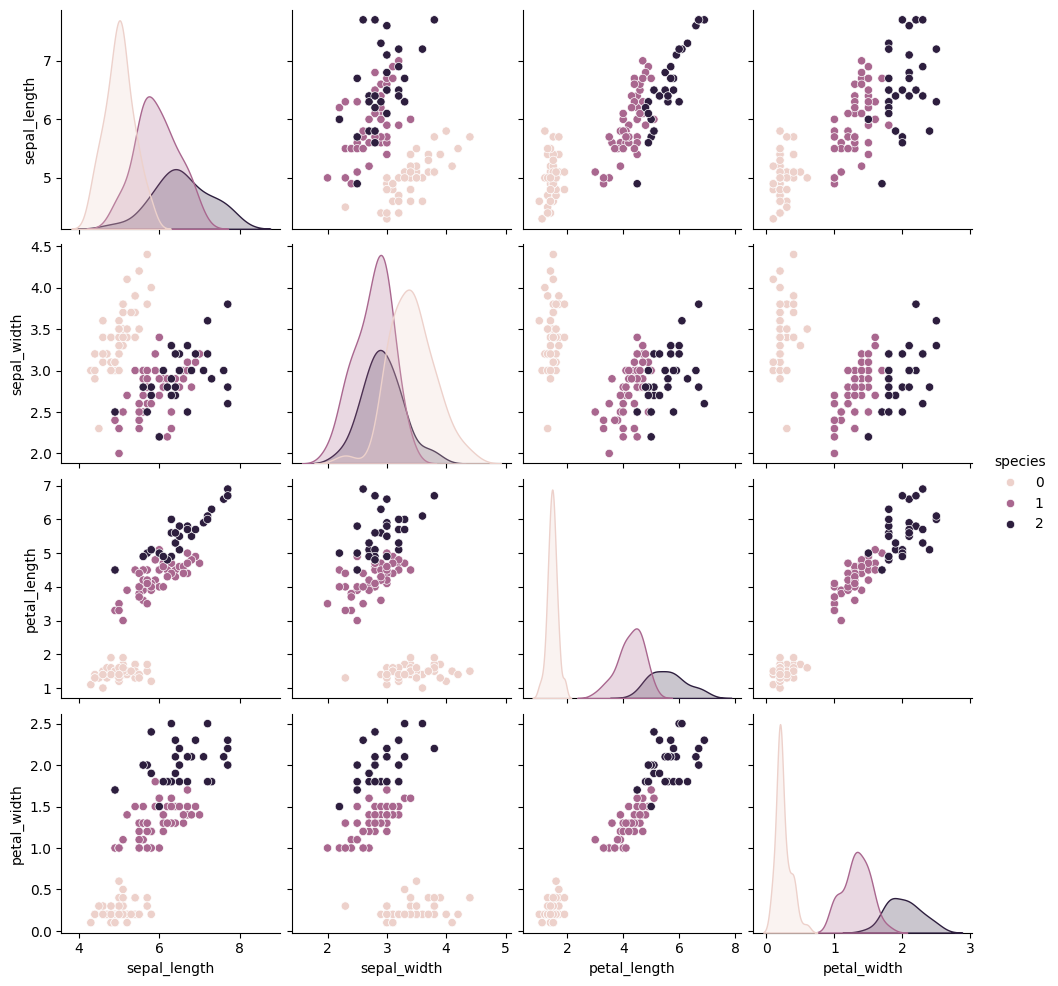

In [241]:
# Pairplot using the target variable as the hue
sns.pairplot(data=df, hue='species')

In [242]:
label_mapping = dict(enumerate(le.classes_))  # Get the label mapping after encoding
print(label_mapping)

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


The Exploratory Data Analysis (EDA) revealed the following:
* The petal length and petal width are closely corelated to the species, while the sepal length are has a good positive corelation to the species.
* The petal width and petal length values are negatively skewed
* The Iris-versicolor(1) and Iris-virginica(2) genarally have larger petal width, petal lengths and sepal lengths than the Iris-setosa(0) species.

## Multi-Class Classification without dataset balancing

### Logistic Regression (One-vs-Rest)

In [243]:
lr_ovr = OneVsRestClassifier(LogisticRegression())
lr_ovr.fit(X_train, y_train)
y_pred_lr_ovr = lr_ovr.predict(X_test)

print("\nLogistic Regression (One-vs-Rest) Performance:")
print(classification_report(y_test, y_pred_lr_ovr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_ovr))


Logistic Regression (One-vs-Rest) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]


In [244]:
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

# Train model with sample weights using OneVsRestClassifier with Logistic Regression
clf = OneVsRestClassifier(LogisticRegression(class_weight=class_weights_dict, max_iter=10000))
clf.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
clf.fit(X_train, y_train, sample_weight=sw_train)

y_pred = clf.predict(X_test)

# Classification Report and Confusion Matrix
print("\nLogistic Regression (One-vs-Rest) Performance balanced weights:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression (One-vs-Rest) Performance balanced weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.60      0.75        15
           2       0.60      1.00      0.75         9

    accuracy                           0.85        39
   macro avg       0.87      0.87      0.83        39
weighted avg       0.91      0.85      0.85        39

Confusion Matrix:
[[15  0  0]
 [ 0  9  6]
 [ 0  0  9]]


### Logistic Regression (One-vs-One)

In [245]:
lr_ovo = OneVsOneClassifier(LogisticRegression())
lr_ovo.fit(X_train, y_train)
y_pred_lr_ovo = lr_ovo.predict(X_test)

print("\nLogistic Regression (One-vs-One) Performance:")
print(classification_report(y_test, y_pred_lr_ovo))


Logistic Regression (One-vs-One) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39



### Softmax Regression (Multinomial Logistic Regression)

In [246]:
softmax = LogisticRegression(solver='lbfgs')
softmax.fit(X_train, y_train)
y_pred_softmax = softmax.predict(X_test)

print("\nSoftmax Regression Performance:")
print(classification_report(y_test, y_pred_softmax))


Softmax Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39



In [247]:
# Evaluation Metrics Function
def evaluate_model(y_true, y_pred, y_proba=None):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if y_proba is not None:
        print("Log Loss:", log_loss(y_true, y_proba))
        print("ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))

In [248]:
# Evaluate Logistic Regression (OvR)
evaluate_model(y_test, y_pred_lr_ovr, lr_ovr.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Log Loss: 0.31997430412578065
ROC AUC Score (OvR): 0.9817901234567902


### Decision Tree

In [249]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree Performance:")
evaluate_model(y_test, y_pred_dt, dt.predict_proba(X_test))


Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Log Loss: 0.9241962407465939
ROC AUC Score (OvR): 0.9745370370370371


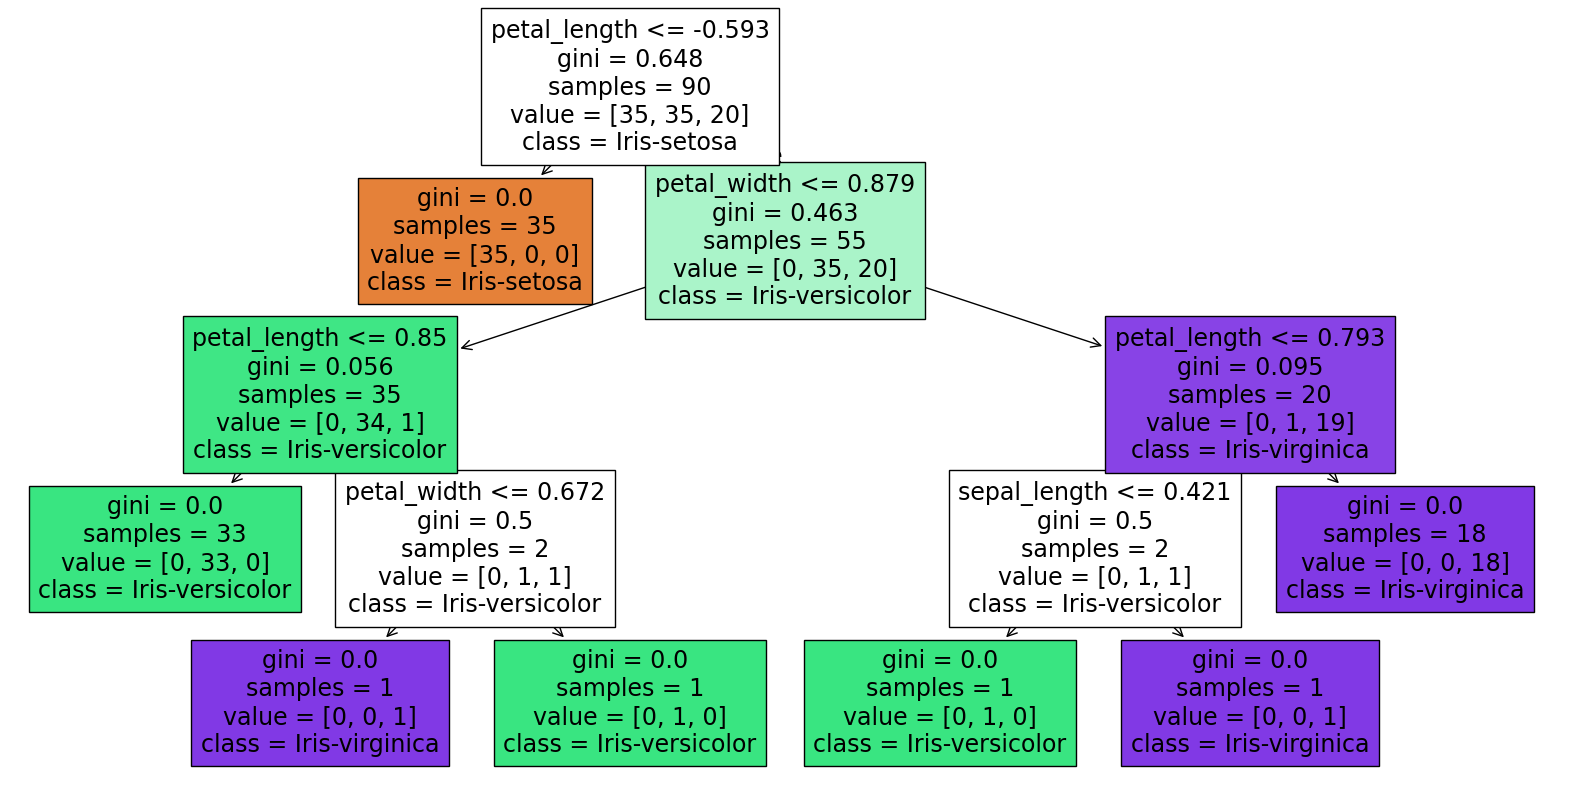

In [250]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()

In [251]:
# Hyperparameter Tuning (Decision Tree)
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("\nBest Parameters for Decision Tree:")
print(grid_search.best_params_)


Best Parameters for Decision Tree:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [252]:
# Evaluate tuned Decision Tree
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

print("\nTuned Decision Tree Performance:")
evaluate_model(y_test, y_pred_best_dt, best_dt.predict_proba(X_test))



Tuned Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Log Loss: 0.9419692453763361
ROC AUC Score (OvR): 0.9734567901234569


## Assignment:
* Try all the other models with balancing the dataset using weights
* Discuss findings
* Plot confusion matrices for all models


### Logistic Regression (One-vs-One) with balanced weights

In [253]:
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

# Train model with sample weights using OneVsRestClassifier with Logistic Regression
clf_ovo = OneVsOneClassifier(LogisticRegression(class_weight=class_weights_dict, max_iter=10000))
clf_ovo.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
clf_ovo.fit(X_train, y_train, sample_weight=sw_train)

y_pred_lr_ovo_b = clf_ovo.predict(X_test)

# Classification Report and Confusion Matrix
print("\nLogistic Regression (One-vs-One) Performance balanced weights:")
print(classification_report(y_test, y_pred_lr_ovo_b))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_ovo_b))


Logistic Regression (One-vs-One) Performance balanced weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.93      0.93        15
           2       0.89      0.89      0.89         9

    accuracy                           0.95        39
   macro avg       0.94      0.94      0.94        39
weighted avg       0.95      0.95      0.95        39

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  1  8]]


### Softmax Regression (Multinomial Logistic Regression) with balanced weights

In [254]:
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

# Train model with sample weights using OneVsRestClassifier with Logistic Regression
clf_sr = LogisticRegression(solver='lbfgs', multi_class='multinomial',class_weight=class_weights_dict, max_iter=10000)
#clf_sr.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
clf_sr.fit(X_train, y_train, sample_weight=sw_train)

y_pred_sr = clf_sr.predict(X_test)

# Classification Report and Confusion Matrix
print("\nSoftmax Regression Performance balanced weights:")
print(classification_report(y_test, y_pred_sr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sr))


Softmax Regression Performance balanced weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.90      1.00      0.95         9

    accuracy                           0.97        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  0  9]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Decision Tree with balanced weights

In [255]:
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

# Train model with sample weights using OneVsRestClassifier with Logistic Regression
dtb = DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42)
dtb.fit(X_train, y_train, sample_weight=sw_train)

y_pred_dtb = dtb.predict(X_test)

# Classification Report and Confusion Matrix
print("\nDecision Tree Performance balanced weights:")
print(classification_report(y_test, y_pred_dtb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dtb))


Decision Tree Performance balanced weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]


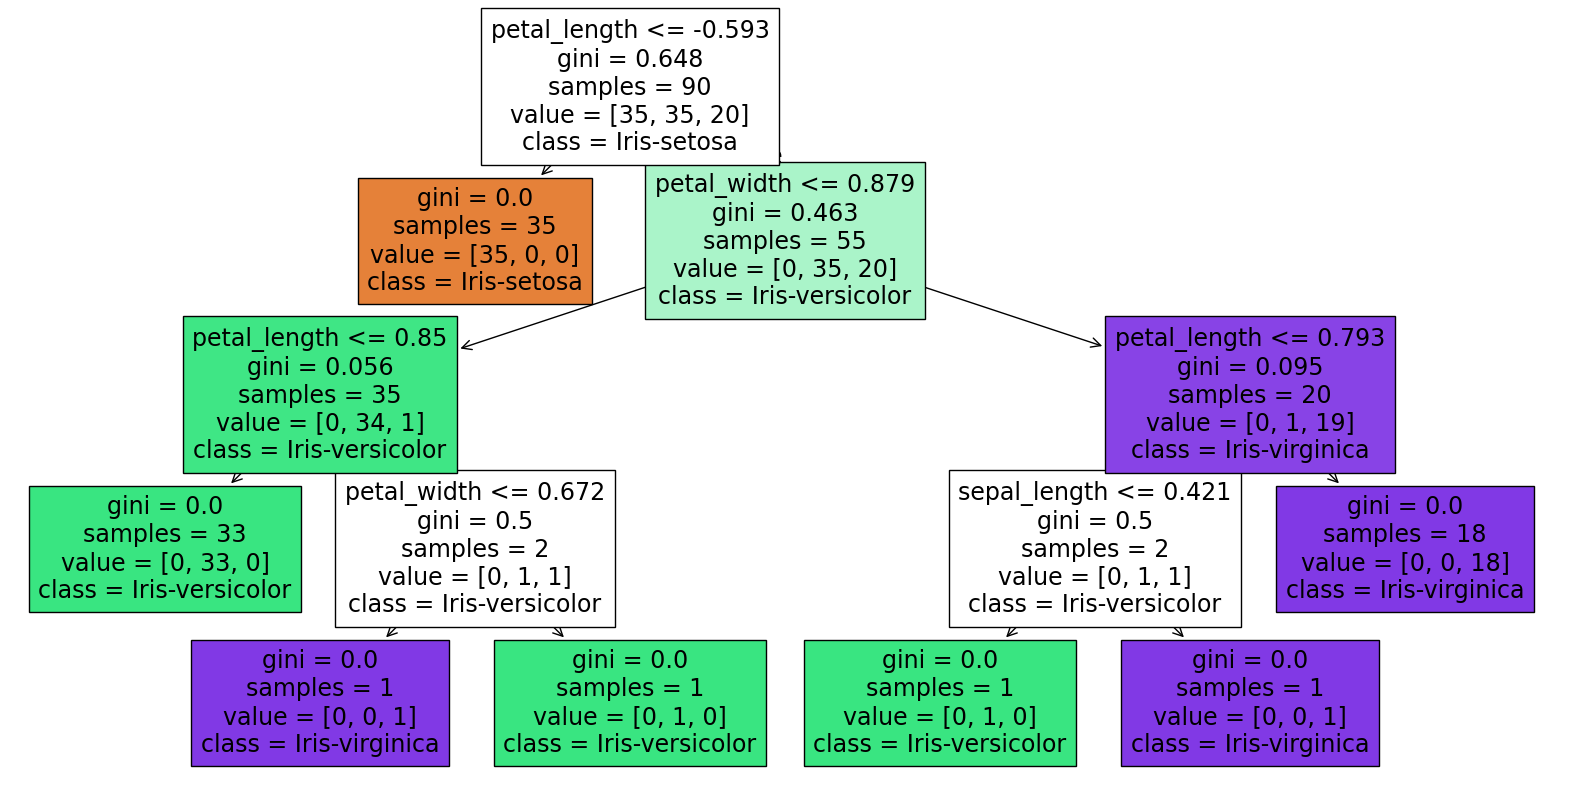

In [256]:
# Visualize New Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()

The decision Matrix is the same as the previous one created with imbalanced data

## Confusion Matrices

### Logistic Regression (OVR)

Text(0.5, 1.0, 'Balanced data')

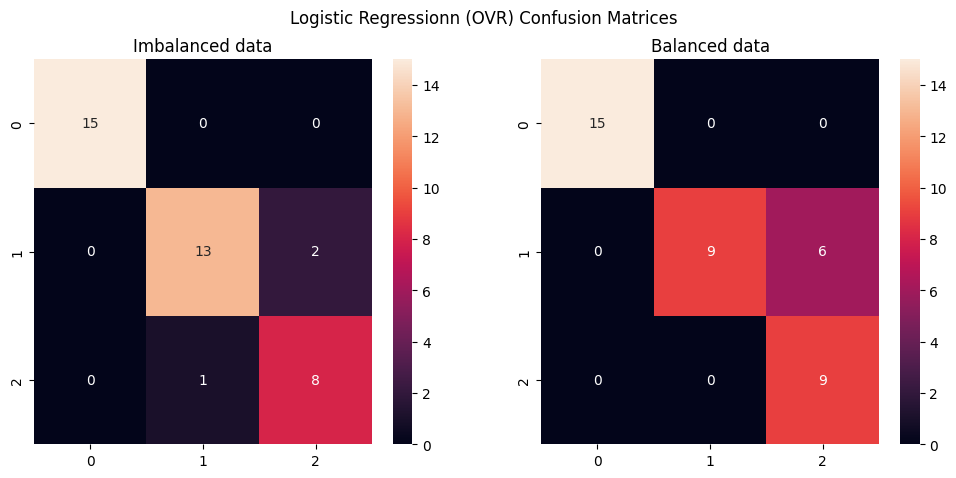

In [257]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Logistic Regressionn (OVR) Confusion Matrices')

cm = confusion_matrix(y_test,y_pred_lr_ovr)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Imbalanced data')

# Using balanced data
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Balanced data')


### Logistic Regression (OVO)

Text(0.5, 1.0, 'Balanced Data')

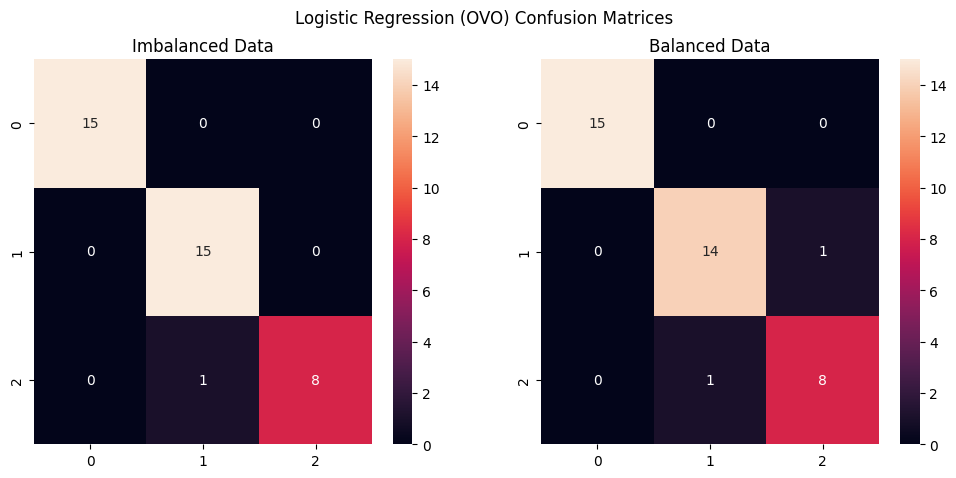

In [258]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Logistic Regression (OVO) Confusion Matrices')

cm = confusion_matrix(y_test,y_pred_lr_ovo)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Imbalanced Data')

# Using balanced weight
cm = confusion_matrix(y_test,y_pred_lr_ovo_b)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Balanced Data')



### Softmax Regression

Text(0.5, 1.0, 'Balanced Data')

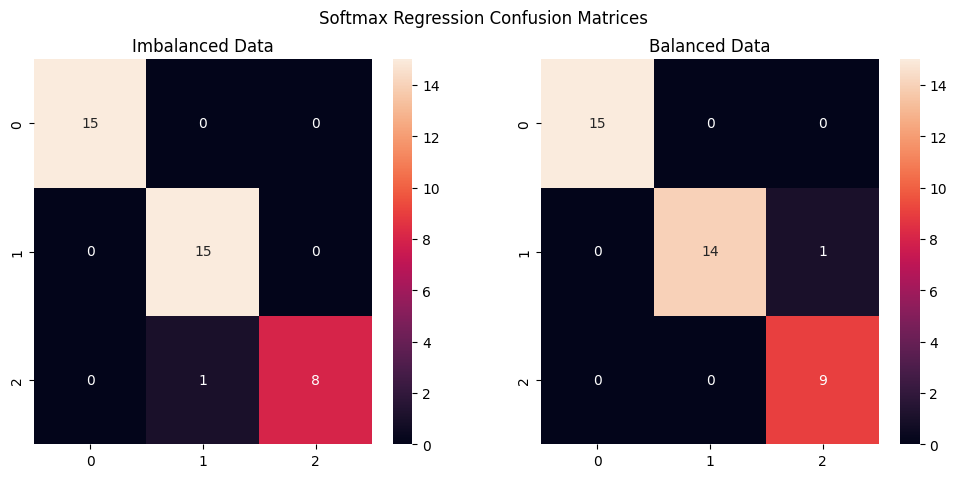

In [259]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Softmax Regression Confusion Matrices')

cm = confusion_matrix(y_test,y_pred_softmax)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Imbalanced Data')

# Using balanced weight
cm = confusion_matrix(y_test,y_pred_sr)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Balanced Data')

### Decision Tree

Text(0.5, 1.0, 'Balanced Data')

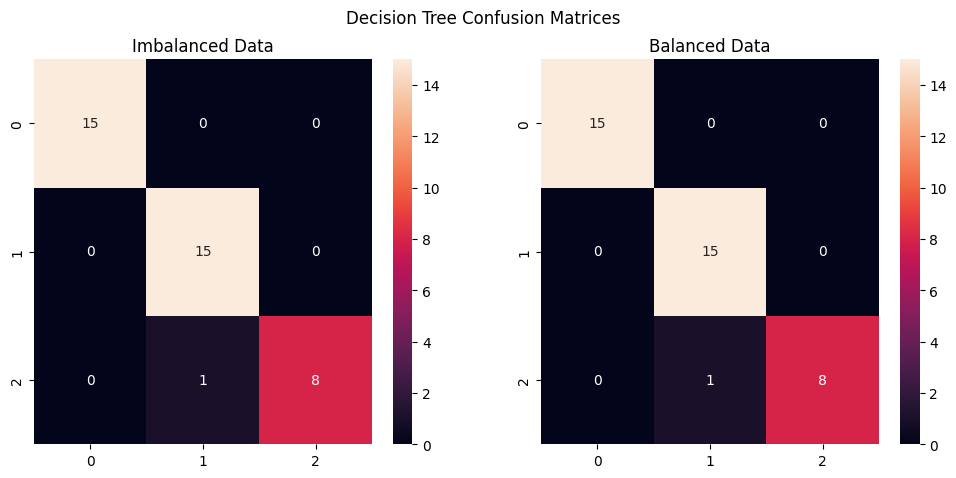

In [260]:
from sklearn.metrics import confusion_matrix

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Decision Tree Confusion Matrices')

cm = confusion_matrix(y_test,y_pred_dt)
sns.heatmap(cm,annot=True, ax=ax1)
ax1.set_title('Imbalanced Data')

# Using balanced weights
cm = confusion_matrix(y_test,y_pred_dtb)
sns.heatmap(cm,annot=True, ax=ax2)
ax2.set_title('Balanced Data')


## Model Comparison

In [261]:
models = {
    'Logistic Regression (OvR)': lr_ovr,
    'Logistic Regression (OvO)': lr_ovo,
    'Softmax Regression': softmax,
    'Decision Tree': dt
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Check if the model is OneVsOneClassifier
    if name == 'Logistic Regression (OvO)':
        # OneVsOneClassifier does not support predict_proba
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': 'Not Available',
            'ROC AUC (OvR)': 'Not Available'
        })
    else:
        # For other models, calculate predict_proba
        y_proba = model.predict_proba(X_test)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba),
            'ROC AUC (OvR)': roc_auc_score(y_test, y_proba, multi_class='ovr')
        })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_df


Model Comparison:


,Model,Accuracy,Precision,Recall,F1,Log Loss,ROC AUC (OvR)
0,Logistic Regression (OvR),0.923077,0.926374,0.923077,0.923775,0.319974,0.98179
1,Logistic Regression (OvO),0.974359,0.975962,0.974359,0.974018,Not Available,Not Available
2,Softmax Regression,0.974359,0.975962,0.974359,0.974018,0.15615,1.0
3,Decision Tree,0.974359,0.975962,0.974359,0.974018,0.924196,0.974537


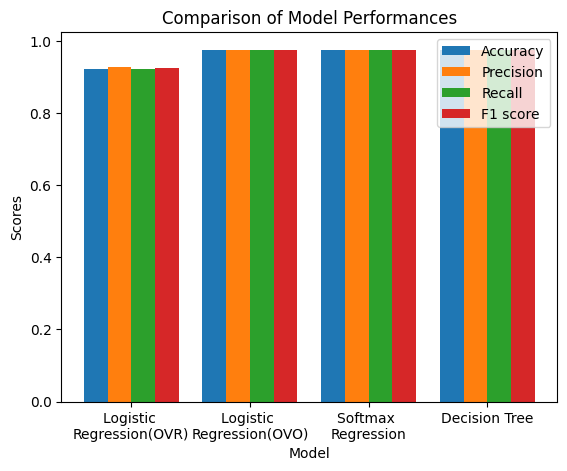

In [262]:
# Bar Chart of Performance Metrics
positions = np.arange(len(metrics_df))
bar_width = 0.2  # Reduced width to fit 4 bars


# Plot bars with appropriate spacing
plt.bar(positions - 1.5 * bar_width, metrics_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(positions - 0.5 * bar_width, metrics_df['Precision'], width=bar_width, label='Precision')
plt.bar(positions + 0.5 * bar_width, metrics_df['Recall'], width=bar_width, label='Recall')
plt.bar(positions + 1.5 * bar_width, metrics_df['F1'], width=bar_width, label='F1 score')


# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Model Performances')

# Adding legend and xticks
plt.legend()
plt.xticks(positions, ['Logistic \nRegression(OVR)', 'Logistic \nRegression(OVO)', 'Softmax \nRegression', 'Decision Tree'])
plt.show()

### For Balanced weights

In [263]:
models = {
    'Logistic Regression (OvR)': clf,
    'Logistic Regression (OvO)': clf_ovo,
    'Softmax Regression': clf_sr,
    'Decision Tree': dtb
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Check if the model is OneVsOneClassifier
    if name == 'Logistic Regression (OvO)':
        # OneVsOneClassifier does not support predict_proba
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': 'Not Available',
            'ROC AUC (OvR)': 'Not Available'
        })
    else:
        # For other models, calculate predict_proba
        y_proba = model.predict_proba(X_test)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba),
            'ROC AUC (OvR)': roc_auc_score(y_test, y_proba, multi_class='ovr')
        })

metrics_balanced_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_balanced_df


Model Comparison:


,Model,Accuracy,Precision,Recall,F1,Log Loss,ROC AUC (OvR)
0,Logistic Regression (OvR),0.846154,0.907692,0.846154,0.846154,0.372352,0.970679
1,Logistic Regression (OvO),0.948718,0.948718,0.948718,0.948718,Not Available,Not Available
2,Softmax Regression,0.974359,0.976923,0.974359,0.974592,0.181748,1.0
3,Decision Tree,0.974359,0.975962,0.974359,0.974018,0.924196,0.974537


## Bar Chart of Model Comparison

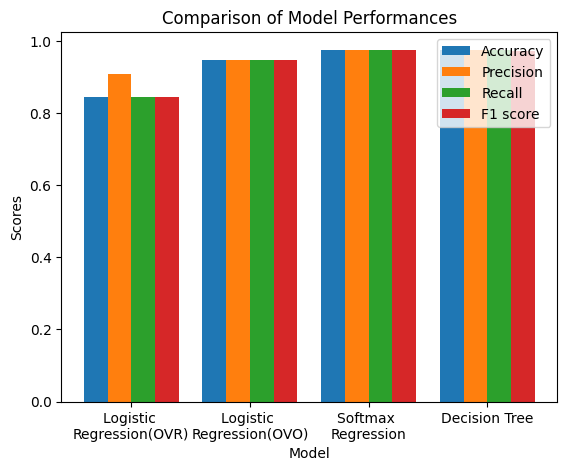

In [264]:
# Bar Chart of Performance Metrics
positions1 = np.arange(len(metrics_balanced_df))
bar_width = 0.2  # Reduced width to fit 4 bars


# Plot bars with appropriate spacing
plt.bar(positions1 - 1.5 * bar_width, metrics_balanced_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(positions1 - 0.5 * bar_width, metrics_balanced_df['Precision'], width=bar_width, label='Precision')
plt.bar(positions1 + 0.5 * bar_width, metrics_balanced_df['Recall'], width=bar_width, label='Recall')
plt.bar(positions1 + 1.5 * bar_width, metrics_balanced_df['F1'], width=bar_width, label='F1 score')


# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Model Performances')

# Adding legend and xticks
plt.legend()
plt.xticks(positions, ['Logistic \nRegression(OVR)', 'Logistic \nRegression(OVO)', 'Softmax \nRegression', 'Decision Tree'])
plt.show()

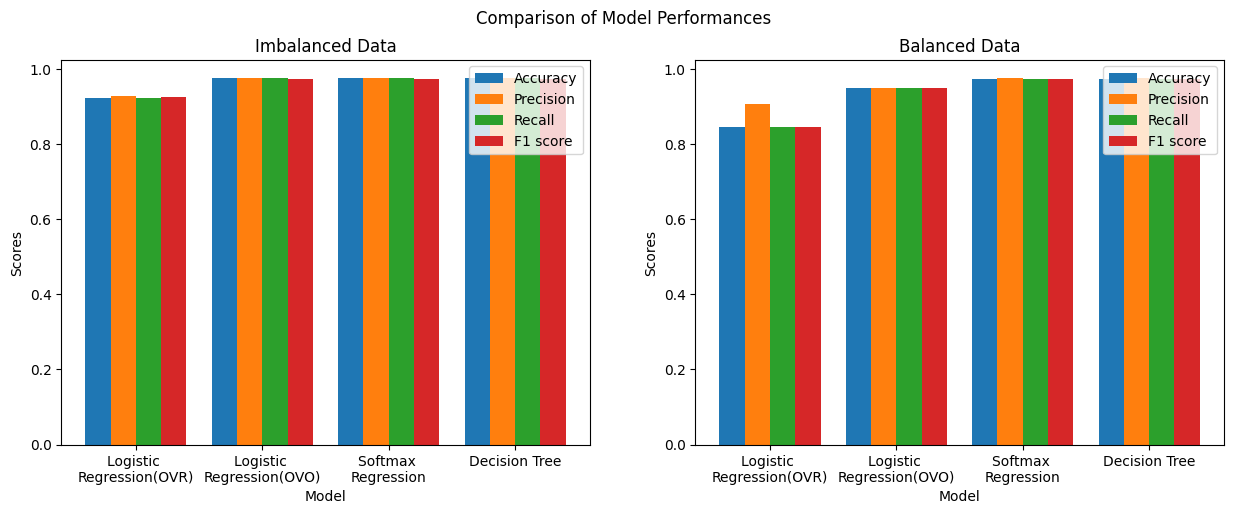

In [265]:
# Comparison of Model for Imbalnced and Balanced Data
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Comparison of Model Performances')
ax1.set_title('Imbalanced Data')
ax2.set_title('Balanced Data')

# Imbalanced Data
# Plot bars with appropriate spacing
ax1.bar(positions - 1.5 * bar_width, metrics_df['Accuracy'], width=bar_width, label='Accuracy')
ax1.bar(positions - 0.5 * bar_width, metrics_df['Precision'], width=bar_width, label='Precision')
ax1.bar(positions + 0.5 * bar_width, metrics_df['Recall'], width=bar_width, label='Recall')
ax1.bar(positions + 1.5 * bar_width, metrics_df['F1'], width=bar_width, label='F1 score')

# Adding labels and title
ax1.set_xlabel('Model')
ax1.set_ylabel('Scores')

# Adding legend and xticks
ax1.legend()
ax1.set_xticks(positions, ['Logistic \nRegression(OVR)', 'Logistic \nRegression(OVO)', 'Softmax \nRegression', 'Decision Tree'])

# Balanced Data
# Plot bars with appropriate spacing
ax2.bar(positions - 1.5 * bar_width, metrics_balanced_df['Accuracy'], width=bar_width, label='Accuracy')
ax2.bar(positions - 0.5 * bar_width, metrics_balanced_df['Precision'], width=bar_width, label='Precision')
ax2.bar(positions + 0.5 * bar_width, metrics_balanced_df['Recall'], width=bar_width, label='Recall')
ax2.bar(positions + 1.5 * bar_width, metrics_balanced_df['F1'], width=bar_width, label='F1 score')

# Adding labels and title
ax2.set_xlabel('Model')
ax2.set_ylabel('Scores')

# Adding legend and xticks
ax2.legend()
ax2.set_xticks(positions, ['Logistic \nRegression(OVR)', 'Logistic \nRegression(OVO)', 'Softmax \nRegression', 'Decision Tree'])
plt.show()



Generally when the balanced weights were used the number of incorectly classified instances increased.
The performance of the Softmax regression and Decision Tree did not change dependent on wether balanced weights were used or not. The Logistic regression (OVR) and (OVO) both had worse performances when the balanced weights were used.